# Processing the results of the experiments

### 1. Exporting the data to csv for further statistical tests in R
Below are defined the all the configuration combinations and the model # associated with each one of them.
Before running this notebook, the log file associated with each configuration was manually renamed
results_model_{model_id}.txt and placed in a Results folder.

In [1]:
model_configs = [
    ("CNN", "within", "full", "all"), #model 1
    ("CNN", "within", "full", "left"), # model 2
    ("CNN", "within", "action", "all"), #model 3
    ("CNN", "within", "action", "left"),  # model 4
    ("LSTM-CNN", "within", "full", "all"),  # model 5
    ("LSTM-CNN", "within", "full", "left"),  # model 6
    ("LSTM-CNN", "within", "action", "all"),  # model 7
    ("LSTM-CNN", "within", "action", "left"),  # model 8
    ("CNN", "LOSO", "full", "all"),  # model 9
    ("CNN", "LOSO", "full", "left"),  # model 10
    ("CNN", "LOSO", "action", "all"),  # model 11
    ("CNN", "LOSO", "action", "left"),  # model 12
    ("LSTM-CNN", "LOSO", "full", "all"),  # model 13
    ("LSTM-CNN", "LOSO", "full", "left"),  # model 14
    ("LSTM-CNN", "LOSO", "action", "all"),  # model 15
    ("LSTM-CNN", "LOSO", "action", "left")  # model 16
]


In [ ]:
#import necessary libraries
import os
import re
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
subject_rows = []

In [5]:
for model_id, (model_type, procedure, interval, electrodes) in enumerate(model_configs, 1):
    filepath = f"./logs/Results/results_model_{model_id}.txt"
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        subj_match = re.match(r"Subject (\d+) final accuracy: ([0-9.]+); precision: ([0-9.]+); recall: ([0-9.]+); F1 score: ([0-9.]+);", line)
        if subj_match:
            subject_rows.append({
                "model_id": model_id,
                "model_type": model_type,
                "procedure": procedure,
                "interval": interval,
                "electrodes": electrodes,
                "subject": int(subj_match[1]),
                "accuracy": float(subj_match[2]),
                "precision": float(subj_match[3]),
                "recall": float(subj_match[4]),
                "f1": float(subj_match[5]),
            })

# Save to CSV
pd.DataFrame(subject_rows).to_csv("subject_metrics.csv", index=False)

Now the data is stored in subject_metrics.csv and will be used by tests.r and plots.r for collecting statistics and visualizations.

### 2. Confusion Matrices analysis
Each log file also stores the confusion matrix on the test data for each subject and the overall.
Below is some analysis.

In [3]:
labels = ['up', 'down', 'right', 'left']

In [2]:
# Adjust these paths as needed
results_dir = "./logs/Results"  # folder with result .txt files
model_files = [f for f in os.listdir(results_dir) if f.endswith(".txt")]

In [6]:
def parse_confusion_matrix(text):
    """Extract the last 4x4 matrix from text, even if multi-line without commas."""
    matches = re.findall(r"\[\[(?:.|\n)*?\]\]", text)
    if not matches:
        return None
    matrix_str = matches[-1]

    # Clean and convert to list of lists
    lines = matrix_str.strip().replace('[', '').replace(']', '').split('\n')
    matrix = [list(map(int, re.findall(r'\d+', line))) for line in lines if re.search(r'\d', line)]

    return np.array(matrix)


In [67]:
all_metrics = []

for file in model_files:
    with open(os.path.join(results_dir, file), 'r') as f:
        content = f.read()

    cm = parse_confusion_matrix(content)
    if cm is None or cm.shape != (4, 4):
        print(f"Skipping {file}: no valid 4x4 confusion matrix found.")
        continue

    # Compute recall and precision per class
    recall = np.diag(cm) / cm.sum(axis=1)
    precision = np.diag(cm) / cm.sum(axis=0)
    f1 = 2 * ((precision * recall)/(precision + recall))

    model_id = int(file.replace("results_model_", "").replace(".txt", ""))
    metrics = {
        "model": model_id,
        "confusion_matrix": cm
    }
    for i, label in enumerate(["up", "down", "right", "left"]):
        #metrics[f"recall_{label}"] = recall[i]
        #metrics[f"precision_{label}"] = precision[i]
        metrics[f"f1_{label}"] = f1[i]

    all_metrics.append(metrics)

# Convert to DataFrame for analysis/export
metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.sort_values("model").reset_index(drop=True)
metrics_df.head(5)

,model,confusion_matrix,f1_up,f1_down,f1_right,f1_left
0,1,"[[136, 140, 151, 132], [122, 156, 146, 135], [...",0.247949,0.276351,0.263205,0.288751
1,2,"[[154, 121, 134, 150], [141, 160, 135, 123], [...",0.268059,0.285970,0.259430,0.282901
2,3,"[[114, 142, 142, 161], [138, 140, 151, 130], [...",0.207840,0.252936,0.247069,0.288179
3,4,"[[143, 136, 148, 132], [135, 145, 127, 152], [...",0.251982,0.263158,0.282648,0.282901
4,5,"[[141, 130, 137, 151], [126, 162, 133, 138], [...",0.255898,0.282476,0.239411,0.263852


In [25]:
summary = metrics_df.iloc[:, 2:].mean()
print(summary)

f1_up       0.252715
f1_down     0.268743
f1_right    0.255033
f1_left     0.278277
dtype: float64


In [ ]:
cm = metrics_df.loc[metrics_df["model"] == 10, "cm"].values[0]

<Figure size 600x500 with 0 Axes>

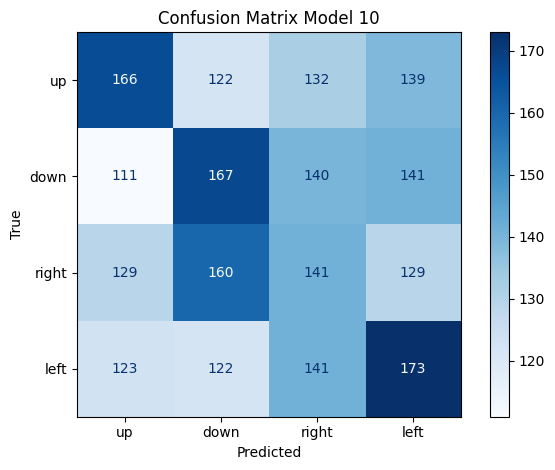

In [65]:
# Class labels
labels = ["up", "down", "right", "left"]

# Create the heatmap
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix Model 10")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()